# Dimensionality Reduction Techniques for satellite Imagery

In [1]:
!pip install earthpy 

     |████████████████████████████████| 1.4MB 5.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.1MB 1.2MB/s 
     |████████████████████████████████| 1.0MB 39.1MB/s 
     |████████████████████████████████| 6.5MB 37.3MB/s 
     |████████████████████████████████| 14.8MB 313kB/s 
  Created wheel for earthpy: filename=earthpy-0.9.2-cp37-none-any.whl size=1365089 sha256=e06a6174337f20926971eacf12f1abf4ceaf1aadde8e19477952ed75d8f78e84
  Stored in directory: /root/.cache/pip/wheels/27/f9/a5/026bb95ef7b12f9343b842da6897b4001c5b902550095cbbbe
Successfully built earthpy


# Import Modules

In [1]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
# from rasterio.plot import plotting_extent
# from rasterio.plot import show
# from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

# Read Data

In [2]:
S_sentinel_bands = glob("/content/drive/MyDrive/Satellite_data/Aquileia_Italy/*B?*.tiff")
S_sentinel_bands.sort()
S_sentinel_bands

['/content/drive/MyDrive/Satellite_data/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/content/drive/MyDrive/Satellite_data/Aquileia_Italy/2019-04-16-00_00_2019-04-16-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/content/drive/MyDrive/Satelli

In [3]:
l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))


In [4]:
arr_st = np.stack(l)

In [5]:
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 689
Width: 1200
Bands: 12


# Visualize Data

## Bands

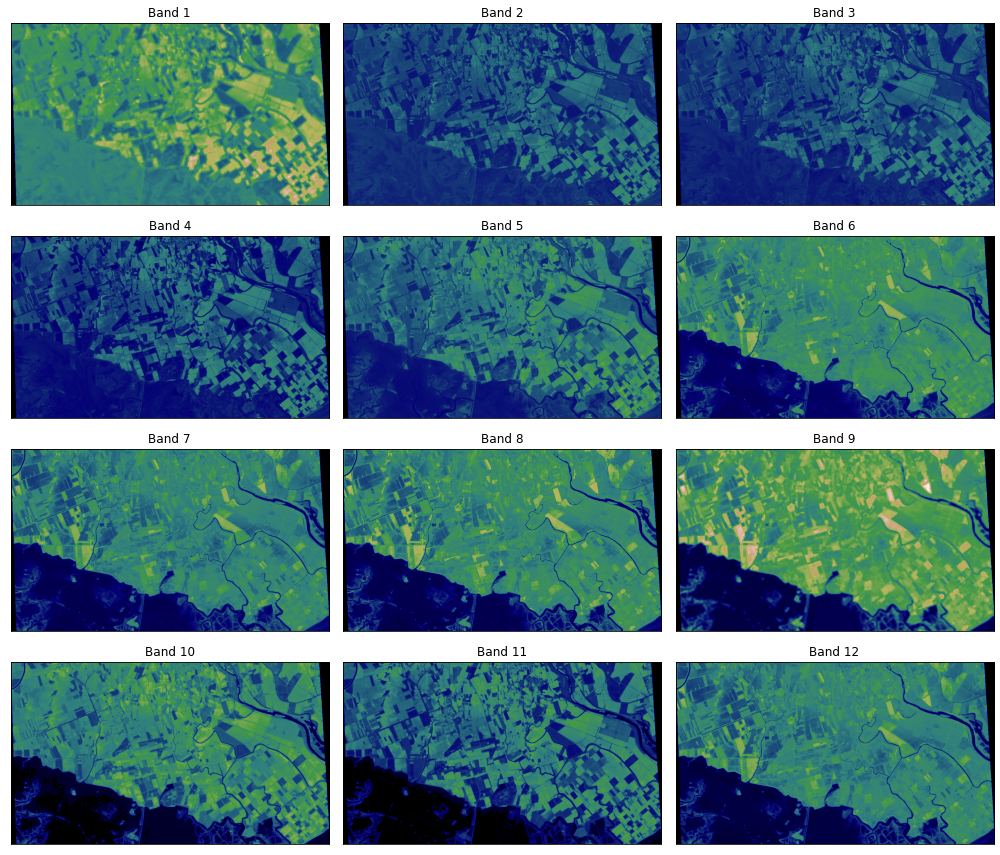

In [6]:
ep.plot_bands(arr_st, cmap = 'gist_earth', figsize = (14, 12), cols = 3, cbar = False)
plt.show()

## RGB Composite Image

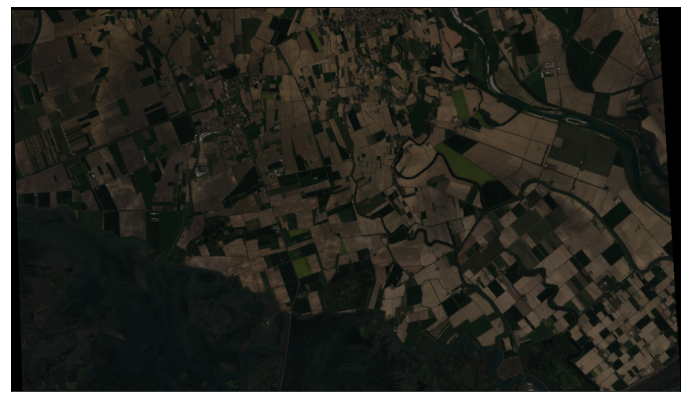

In [7]:
rgb = ep.plot_rgb(arr_st, 
                  rgb=(3,2,1), 
                  figsize=(12, 16), 
                  # title='RGB Composite Image'
                  )

plt.show()

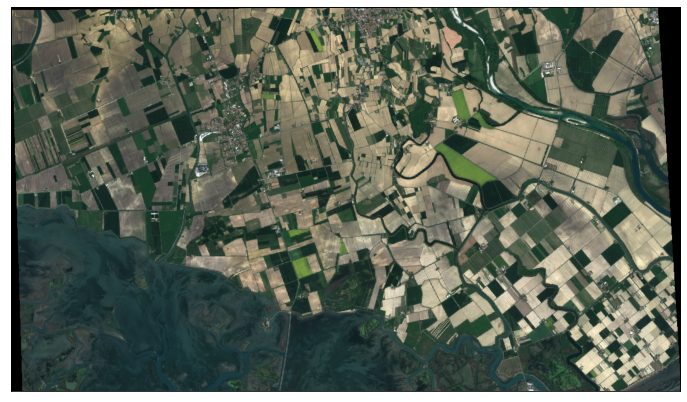

In [8]:
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.02,
    figsize=(12, 16),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()

## Data Distribution of Bands

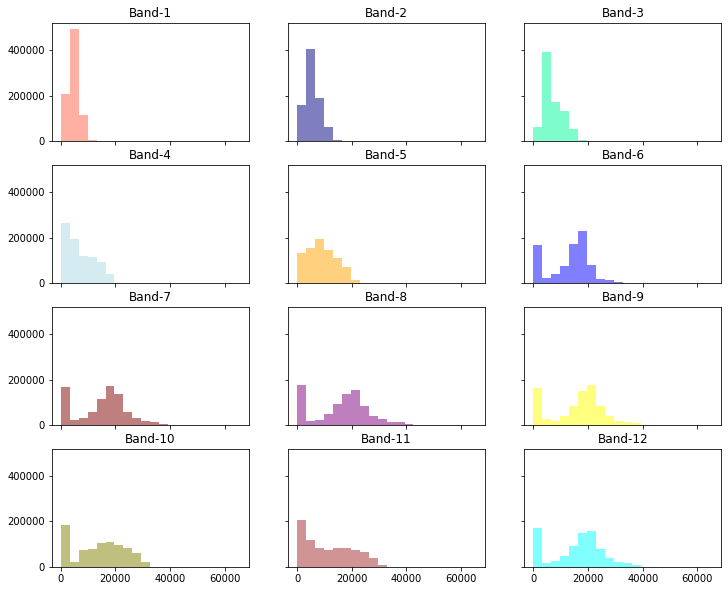

In [9]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

ep.hist(arr_st, 
         colors = colors,
        title=[f'Band-{i}' for i in range(1, 13)], 
        cols=3, 
        alpha=0.5, 
        figsize = (12, 10)
        )

plt.show()

# Preprocessing 

In [10]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

(689, 1200, 12)

In [11]:
x.reshape(-1, 12).shape, 954*298

((826800, 12), 284292)

In [12]:
from sklearn.preprocessing import StandardScaler

X_data = x.reshape(-1, 12)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(826800, 12)

## Principal Component Analysis (PCA)

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 4)

pca.fit(X_scaled)

data = pca.transform(X_scaled)

In [14]:
data.shape

(826800, 4)

In [15]:
pca.explained_variance_ratio_

array([0.68953814, 0.27498282, 0.01739938, 0.00944748])

In [16]:
np.sum(pca.explained_variance_ratio_)

0.9913678224195883

### Visualize Bands after PCA

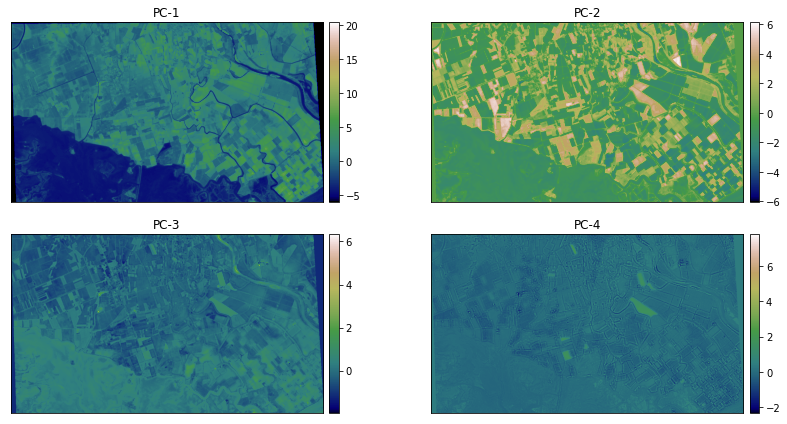

In [17]:
ep.plot_bands(np.moveaxis(data.reshape((689, 1200, data.shape[1])), -1, 0),
              cmap = 'gist_earth',
              cols = 2,
              figsize = (12, 6),
              title = [f'PC-{i}' for i in range(1,5)])

plt.show()

## Incremental PCA

In [22]:
from sklearn.decomposition import IncrementalPCA
from scipy import sparse

transformer = IncrementalPCA(n_components=4, batch_size=800)
X_sparse = sparse.csr_matrix(X_scaled)
X_transformed = transformer.fit_transform(X_sparse)

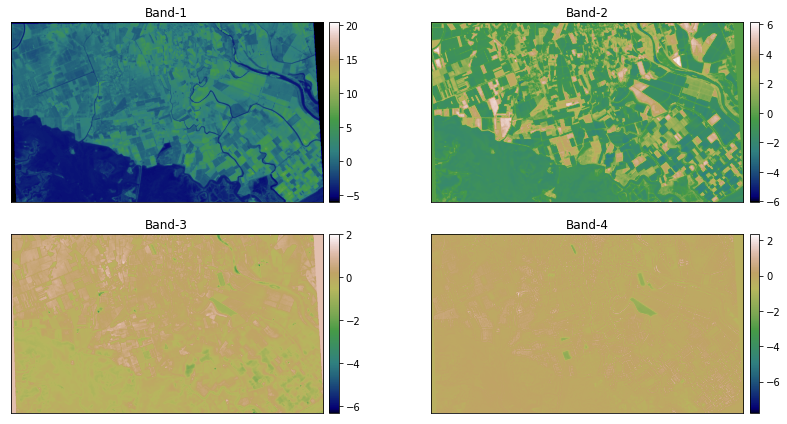

In [23]:
ep.plot_bands(np.moveaxis(X_transformed.reshape((689, 1200, data.shape[1])), -1, 0),
              cmap = 'gist_earth',
              cols = 2,
              figsize = (12, 6),
              title = [f'Band-{i}' for i in range(1,5)])

plt.show()

## Independent Component Analysis (ICA)

In [18]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components = 4, random_state=6)


ica_data = ica.fit_transform(X_scaled)


In [19]:
ica_data.shape

(826800, 4)

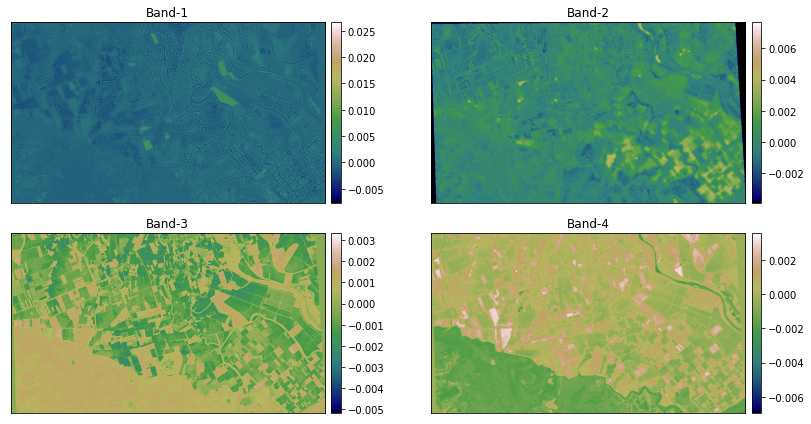

In [20]:
ep.plot_bands(np.moveaxis(ica_data.reshape((689, 1200, data.shape[1])), -1, 0),
              cmap = 'gist_earth',
              cols = 2,
              figsize = (12, 6),
              title = [f'Band-{i}' for i in range(1,5)])

plt.show()



---

